In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import mesa.batchrunner as batch_run

from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()
        
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
    


class MoneyModel(Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )
        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
            
            
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if agent.wealth > 0:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 0
    else:
        portrayal["Color"] = "grey"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2
    return portrayal

<AxesSubplot:>

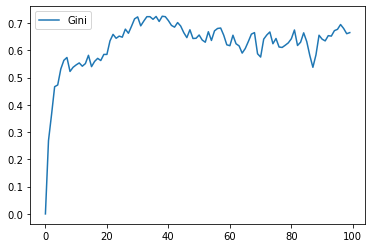

In [2]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()
    
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [3]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

<AxesSubplot:>

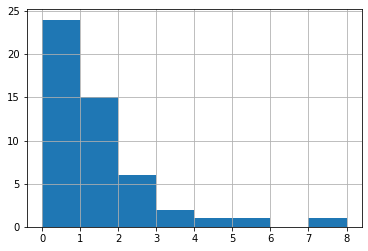

In [4]:
# Plot the wealth at the end of the simulation
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max() + 1))

<AxesSubplot:xlabel='Step'>

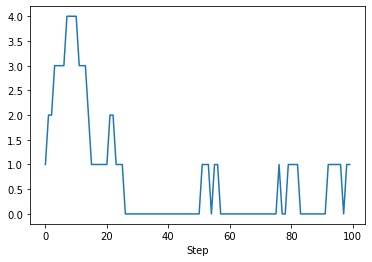

In [5]:
# Plot the wealth of a specific agent
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

In [6]:
# Make a batch run
# ----------------

from mesa.batchrunner import batch_run

# Parameters for the model
params = {"width": 10, "height": 10, "N": range(10, 500, 10)}

results = batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=None,
    data_collection_period=1,
    display_progress=True,
)

245it [00:12, 19.64it/s]


In [7]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'Gini', 'AgentID',
       'Wealth'],
      dtype='object')


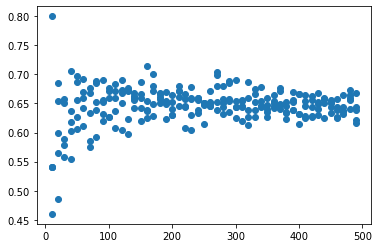

In [8]:
import matplotlib.pyplot as plt

results_filtered = results_df[(results_df.AgentID == 0) & (results_df.Step == 100)]
N_values = results_filtered.N.values
gini_values = results_filtered.Gini.values
plt.scatter(N_values, gini_values)

In [9]:
# Initialize the grid
grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)

In [10]:
chart = ChartModule([{"Label": "Gini",
                      "Color": "Black"}],
                    data_collector_name='datacollector')

server = ModularServer(MoneyModel,
                       [grid, chart],
                       "Money Model",
                       {"N":100, "width":10, "height":10})

server.port = 8522 # The default
server.launch();

Interface starting at http://127.0.0.1:8522


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step